In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

import os
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
from conf_solv.dataloaders.loader import IONIC_SOLVENTS

T = 298  # K
R = 0.0019872  # kcal/(mol*K)

solvent_dict = {
#     'Acetat': ('CC(=O)[O-]', 'Acetate'),
    'Acetic-acid': ('CC(=O)O', 'Acetic acid', 6.15, 'small acid'),
    'Aceton': ('CC(=O)C', 'Acetone', 20.7, 'polar aprotic'),
    'Acetonitrile': ('CC#N', 'Acetonitrile', 37.5, 'polar aprotic'),
    'Ammonia': ('N', 'Ammonia', 16.61, 'polar aprotic'),
#     'Ammonium': ('[NH4+]', 'Ammonium', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc. 
    'Benzene': ('c1ccccc1', 'Benzene', 2.28, 'nonpolar'),
#     'Benzoat': ('[O-]C(=O)c1ccccc1', 'Benzoate'),
    'Benzylacetat': ('CC(=O)OCc1ccccc1', 'Benzyl acetate', 5.34, 'polar aprotic'),
    'Butanon': ('CCC(=O)C', 'Butanone', 18.85, 'polar aprotic'),
#     'Chloride': ('[Cl-]', 'Chloride', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc.
    'Chloroform': ('C(Cl)(Cl)Cl', 'Chloroform', 4.8, 'nonpolar'),
    'Cyclohexan': ('C1CCCCC1', 'Cyclohexane', 2.02, 'nonpolar'),
    'Di-2-butylamin': ('CC[C@H](C)N[C@H](C)CC', 'Di-2-butylamine', 4.71, 'nonpolar'),
    'Dichlormethan': ('C(Cl)Cl', 'Dichloromethane', 8.93, 'polar aprotic'),
    'Diethanolamin': ('OCCNCCO', 'Diethanolamine', 25.75, 'polar protic'),
#     'Diethanolammonium': ('OCC[NH2+]CCO', 'Diethanolammonium'),
#     'Diethylenamin': ('CCNCC', 'Diethylamine', 3.8, 'nonpolar'), #Average of three sources - 3.6, 3.8, 3.92 all reported.
#     'Diethylenammonium': ('CC[NH2+]CC', 'Diethylenammonium'),
    'Diethylether': ('CCOCC', 'Diethylether',4.33, 'nonpolar'),
    'Dioctylether': ('CCCCCCCCOCCCCCCC', 'Dioctylether', 2, 'nonpolar'), #Estimate
    'DMA': ('CC(=O)N(C)C', 'DMA', 37.8, 'polar aprotic'),
    'DMF': ('CN(C)C=O', 'DMF', 36.7, 'polar aprotic'),
    'DMSO': ('CS(=O)C', 'DMSO', 46.7, 'polar aprotic'),
    'EC': ('C1COC(=O)O1', 'EC', 89.78, 'polar aprotic'),
    'EMC': ('CCOC(=O)OC', 'EMC', 2.99, 'nonpolar'),
    'Ethanol': ('CCO', 'Ethanol', 24.55, 'polar protic'),
    'Ethylacetat': ('CCOC(=O)C', 'Ethyl acetate', 6.02, 'polar aprotic'),
#     'Ethylenamin': ('C=CN', 'Ethylenamine', 6.94, 'polar protic'),
#     'Ethylenammonium': ('CC[NH3+]', 'Ethylenammonium'),
    'Ethylenglykol': ('OCCO', 'Ethylene glycol', 37.0, 'polar protic'),
#     'Formiat': ('C(=O)[O-]', 'Formate'),
    'Formic-acid': ('O=CO', 'Formic acid', 51.1, 'small acid'),
    'g-Butyrolacton': ('O=C1CCCO1', 'γ-Butyrolactone', 41.68, 'polar aprotic'),
    'Glycerin': ('OCC(O)CO', 'Glycerol', 46.5, 'polar protic'),
    'H2O': ('O', 'Water', 80.1, 'water'),
    'H2SO4': ('O=S(=O)(O)O', 'Sulfuric acid', 100, 'small acid'), #Lots of varying reports 21.9, 100, 84, 80, 106. Chosen 100 for now.
    'Hexafluorbenzol': ('Fc1c(F)c(F)c(F)c(F)c1F', 'Hexafluorobenzene',  2.05, 'nonpolar'),
    'Isooctane': ('CC(C)CC(C)(C)C', 'Isooctane', 1.94, 'nonpolar'),
    'Isopropanol': ('CC(O)C', 'Isopropanol', 17.9, 'polar protic'),
#     'Methanolat': ('C[O-]', 'Methanolate'),
    'n-Hexan': ('CCCCCC', 'n-Hexane', 1.88, 'nonpolar'),
    'Nonandecanol': ('CCCCCCCCCCCCCCCCCCCO', 'Nonandecanol', 3.82, 'fatty alcohol'),
    'Octanol': ('CCCCCCCCO', 'Octanol', 10.3, 'fatty alcohol'),
    'o-Dichlorbenzol': ('Clc1ccccc1Cl', 'o-Dichlorobenzene', 9.93, 'nonpolar'),
#     'Oleic-methyl-ester': ('CCCCCCCCC=CCCCCCCCC(=O)OC', 'Oleic methyl ester', 3.21, 'nonpolar'),
    'Perfluoro-hexan': ('C(C(C(C(F)(F)F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F', 'Perfluorohexane', 1.57, 'nonpolar'),
    'Propylenglykol': ('C[C@@H](O)CO', 'Propylene glycol', 32.0, 'polar protic'),
#     'Tetraethylenammonium': ('CC[N+](CC)(CC)CC', 'Tetraethylenammonium'),
    'THF': ('O1CCCC1', 'THF', 7.58, 'polar aprotic'),
    'Toluol': ('Cc1ccccc1', 'Toluene', 2.38, 'nonpolar'),
    'Tributylphosphat': ('O=P(OCCCC)(OCCCC)OCCCC', 'Tributyl phosphate', 8.29, 'polar aprotic'),
    'Triethanolamin': ('OCCN(CCO)CCO', 'Triethanolamine', 28.11, 'polar protic'),
#     'Triethanolammonium': ('OCC[NH+](CCO)CCO', 'Triethanolammonium'),
#     'Triethylenamin': ('CCN(CC)CC', 'Triethylamine', 2.42, 'nonpolar'),
#     'Triethylenammonium': ('CC[NH+](CC)CC', 'Triethylammonium'),
    'Triglyme': ('COCCOCCOCCOC', 'Triglyme', 7.50, 'polar aprotic'),
    'Urea': ('NC(N)=O', 'Urea', 2.9, 'urea'),
}

# https://www.engineeringtoolbox.com/liquid-dielectric-constants-d_1263.html
# https://people.chem.umass.edu/xray/solvent.html
# https://depts.washington.edu/eooptic/linkfiles/dielectric_chart%5B1%5D.pdf

solvent_keys = list(solvent_dict.keys())
solvent_smiles = list(zip(*solvent_dict.values()))[0]
solvent_names = list(zip(*solvent_dict.values()))[1]
dielctric_constants = list(zip(*solvent_dict.values()))[2]
solvent_classes = list(zip(*solvent_dict.values()))[3]
solvent_class_dict = {s:c for s,c in zip(solvent_keys, solvent_classes)}
solvent_name_class_dict = {s:c for s,c in zip(solvent_keys, solvent_classes)}
dielectric_dict = {s:e for s,e in zip(solvent_keys, dielctric_constants)}
dielectric_name_dict = {s:e for s,e in zip(solvent_names, dielctric_constants)}
solvent_key_name_dict = {k:n for k,n in zip(solvent_keys, solvent_names)}
solvent_key_smiles_dict = {k:n for k,n in zip(solvent_keys, solvent_smiles)}
# smiles_to_names_dict = {k:v for k,v in zip(solvents, solvent_names)}
# solvent_class_dict = {v[1]:v[3] for k,v in solvent_dict.items()}
# solvent_class_order = ['nonpolar', 'fatty alcohol', 'polar aprotic', 'polar protic', 'small acid', 'urea', 'water']

KJ_TO_KCAL = 0.239006

id_to_smi = pd.read_csv("../data/full/id_smiles_all.smi").set_index("ID")
id_to_smi = id_to_smi.groupby(id_to_smi.index).first()
id_to_smi["canon_smi"] = id_to_smi["SMILES"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [80]:
# for s in ordered_solvents:
#     print(f"{solvent_key_name_dict[s]} & \ce\{{Chem.rdMolDescriptors.CalcMolFormula(Chem.MolFromSmiles(solvent_key_smiles_dict[s]))}\} & {solvent_class_dict[s]} & {dielectric_dict[s]} \\\\")

In [22]:
def add_mol_properties(test_mol_df):
    
    present_mol_ids = test_mol_df.mol_id.unique()
    mol_id_to_smi_dict = {m_id: id_to_smi.loc[m_id]["canon_smi"] for m_id in present_mol_ids}
    mol_id_to_mol_dict = {m_id: Chem.MolFromSmiles(mol_id_to_smi_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_rotatable_bonds = {m_id: AllChem.CalcNumRotatableBonds(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_num_rings = {m_id: AllChem.CalcNumRings(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_hbd = {m_id: AllChem.CalcNumHBD(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_hba = {m_id: AllChem.CalcNumHBA(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_mol_weight = {m_id: AllChem.CalcExactMolWt(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_atoms = {m_id: [a.GetSymbol() for a in mol_id_to_mol_dict[m_id].GetAtoms()] for m_id in present_mol_ids}
    mol_id_to_max_fc = {m_id: np.max([a.GetFormalCharge() for a in mol_id_to_mol_dict[m_id].GetAtoms()]) for m_id in present_mol_ids}
    mol_id_to_min_fc = {m_id: np.min([a.GetFormalCharge() for a in mol_id_to_mol_dict[m_id].GetAtoms()]) for m_id in present_mol_ids}
    mol_id_to_fc = {m_id: Chem.GetFormalCharge(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    
    test_mol_df["solute_smi"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_smi_dict[x])
    test_mol_df["mol"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_mol_dict[x])
    test_mol_df["n_rotatable_bonds"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_rotatable_bonds[x])
    test_mol_df["num_rings"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_num_rings[x])
    test_mol_df["n_hbd"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_hbd[x])
    test_mol_df["n_hba"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_hba[x])
    test_mol_df["mol_weight"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_mol_weight[x])
    test_mol_df["atoms"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_atoms[x])
    test_mol_df["max_fc"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_max_fc[x])
    test_mol_df["min_fc"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_min_fc[x])
    test_mol_df["fc"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_fc[x])
    
    test_mol_df["ion"] = "none"
    test_mol_df.loc[test_mol_df["fc"]>0, "ion"] = "cation"
    test_mol_df.loc[test_mol_df["fc"]<0, "ion"] = "anion"
    test_mol_df.loc[(test_mol_df["fc"]==0) & ((test_mol_df["max_fc"]!=0) | (test_mol_df["min_fc"]!=0)), "ion"] = "zwitterion"

    bins = [0, 100, 200, 300, 400, 500 ,600]
    test_mol_df["mol_weight_binned"] = pd.cut(test_mol_df["mol_weight"], bins)
    
    rotatable_bond_bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 12]
    test_mol_df["n_rotatable_bonds_binned"] = pd.cut(test_mol_df["n_rotatable_bonds"], rotatable_bond_bins)
    
    # can only run this line once
    unique_atoms = set().union(*test_mol_df.atoms.values.tolist())
    atoms_df = pd.DataFrame(list(test_mol_df.apply(lambda row: {a:row["atoms"].count(a) for a in unique_atoms}, axis=1)))
    test_mol_df = pd.concat([test_mol_df, atoms_df], axis=1)
    
    test_mol_df["n_hetero_atoms"] = test_mol_df[unique_atoms].sum(axis=1) - test_mol_df[["C"]].sum(axis=1)
    test_mol_df["percent_hetero_atoms"] = test_mol_df["n_hetero_atoms"] / test_mol_df[unique_atoms].sum(axis=1)
    
    return test_mol_df

In [3]:
energies_df = pd.read_pickle('../data/debug/free_energy.pkl.gz')
numerical_columns = ["dE(gas)", "dG(gas)", "dG(solution)", "E(gas)", \
                     "G(gas)", "G(solution)", "G(solvation)", "G(RRHO)"]
energies_df[numerical_columns] = energies_df[numerical_columns] * KJ_TO_KCAL
energies_df = energies_df.set_index(["mol_id", "solvent", "conf_id"]).sort_index()

In [4]:
coords_df = pd.read_pickle('../data/debug/dft_coords.pkl.gz')

In [5]:
exp_dirs = ["../exps/2022_07_28/random/seed0_split0"]#, "../exps/2022_07_28/scaffold/seed0_split0"]


dfs = []
for i, exp_dir in enumerate(exp_dirs):
    for pred_csv in glob(f"{exp_dir}/*predictions.csv"):
        df = pd.read_csv(pred_csv)
        df["split"] = exp_dir.split("/")[-2]
        dfs.append(df)
data_df = pd.concat(dfs)

# drop 'Oleic-methyl-ester'
data_df = data_df[data_df["solvent"]!='Oleic-methyl-ester']
data_df = data_df[~data_df["solvent"].isin(IONIC_SOLVENTS)]

data_df["dG_pred (kcal/mol)"] = data_df["dG_pred (kJ/mol)"] * KJ_TO_KCAL
data_df["dG_true (kcal/mol)"] = data_df["dG_true (kJ/mol)"] * KJ_TO_KCAL
data_df["ARE (kcal/mol)"] = np.abs(data_df["dG_pred (kcal/mol)"] - data_df["dG_true (kcal/mol)"])
data_df["SRE (kcal/mol)"] = np.square(data_df["dG_pred (kcal/mol)"] - data_df["dG_true (kcal/mol)"])
data_df["solvent_class"] = data_df["solvent"].apply(lambda x: solvent_class_dict[x])

data_df.sort_values(["mol_id", "solvent"], inplace=True)
data_df["true_boltzmann_factor"] = data_df.groupby(["mol_id", "solvent"])["dG_true (kcal/mol)"]\
                                          .apply(lambda x: np.exp(-x/(R*T)) / np.sum(np.exp(-x/(R*T)))).values
data_df["pred_boltzmann_factor"] = data_df.groupby(["mol_id", "solvent"])["dG_pred (kcal/mol)"]\
                                          .apply(lambda x: np.exp(-x/(R*T)) / np.sum(np.exp(-x/(R*T)))).values

# create mol df
mol_df = data_df.groupby(["mol_id", "solvent"])["conf_id"].apply(len)
mol_df = mol_df.reset_index(name="n_confs")

# prep data_df for join
data_df = data_df.set_index(["mol_id", "solvent", "conf_id"]).sort_index()
data_df = data_df.join(energies_df[["G(solution)"]], how='left')

# data_df["true_order"] = data_df.reset_index().groupby(["mol_id", "solvent"]).apply(lambda x: x["dG_true (kcal/mol)"]\
#                                .argsort()).reset_index()\
#                                .sort_values(["mol_id", "solvent"])["dG_true (kcal/mol)"].values
# data_df["pred_order"] = data_df.reset_index().groupby(["mol_id", "solvent"]).apply(lambda x: x["dG_pred (kcal/mol)"]\
#                                .argsort()).reset_index()\
#                                .sort_values(["mol_id", "solvent"])["dG_pred (kcal/mol)"].values

In [15]:
# test_mol_ids = ["molecule_58260", "epa_DTXCID60755100", "molecule_103475843"]
# test_data_df = data_df[data_df["mol_id"].isin(test_mol_ids)].sort_values(["mol_id", "solvent"])
data_df

dG_pred (kJ/mol)  dG_true (kJ/mol)  \
mol_id          solvent         conf_id                                         
ct_AIIV7HW50KNN Acetic-acid     conf00001          0.073486             0.000   
                                conf00002          0.000000             4.272   
                                conf00003          2.159424             6.445   
                Aceton          conf00001          0.000000             0.000   
                                conf00002          0.439453             4.444   
...                                                     ...               ...   
pka_extern_7054 n-Hexan         conf00007          1.178711             0.125   
                o-Dichlorbenzol conf00001          0.000000             0.117   
                                conf00004          3.313889             1.765   
                                conf00006          0.131348             0.000   
                                conf00007          1.182022             0.366   

                                           ensemble  dG_pred (kcal/mol)  \
mol_id          solvent         conf_id                                   
ct_AIIV7HW50KNN Acetic-acid     conf00001         0            0.017564   
                                conf00002         0            0.000000   
                                conf00003         0            0.516115   
                Aceton          conf00001         0            0.000000   
                                conf00002         0            0.105032   
...                                             ...                 ...   
pka_extern_7054 n-Hexan         conf00007         0            0.281719   
                o-Dichlorbenzol conf00001         0            0.000000   
                                conf00004         0            0.792039   
                                conf00006         0            0.031393   
                                conf00007         0            0.282510   

                                           dG_true (kcal/mol)  ARE (kcal/mol)  \
mol_id          solvent         conf_id                                         
ct_AIIV7HW50KNN Acetic-acid     conf00001            0.000000        0.017564   
                                conf00002            1.021034        1.021034   
                                conf00003            1.540394        1.024278   
                Aceton          conf00001            0.000000        0.000000   
                                conf00002            1.062143        0.957111   
...                                                       ...             ...   
pka_extern_7054 n-Hexan         conf00007            0.029876        0.251843   
                o-Dichlorbenzol conf00001            0.027964        0.027964   
                                conf00004            0.421846        0.370194   
                                conf00006            0.000000        0.031393   
                                conf00007            0.087476        0.195034   

                                           SRE (kcal/mol)  solvent_class  \
mol_id          solvent         conf_id                                    
ct_AIIV7HW50KNN Acetic-acid     conf00001        0.000308     small acid   
                                conf00002        1.042510     small acid   
                                conf00003        1.049146     small acid   
                Aceton          conf00001        0.000000  polar aprotic   
                                conf00002        0.916061  polar aprotic   
...                                                   ...            ...   
pka_extern_7054 n-Hexan         conf00007        0.063425       nonpolar   
                o-Dichlorbenzol conf00001        0.000782       nonpolar   
                                conf00004        0.137043       nonpolar   
                                conf00006        0.000986       nonpolar   
                                conf00007      

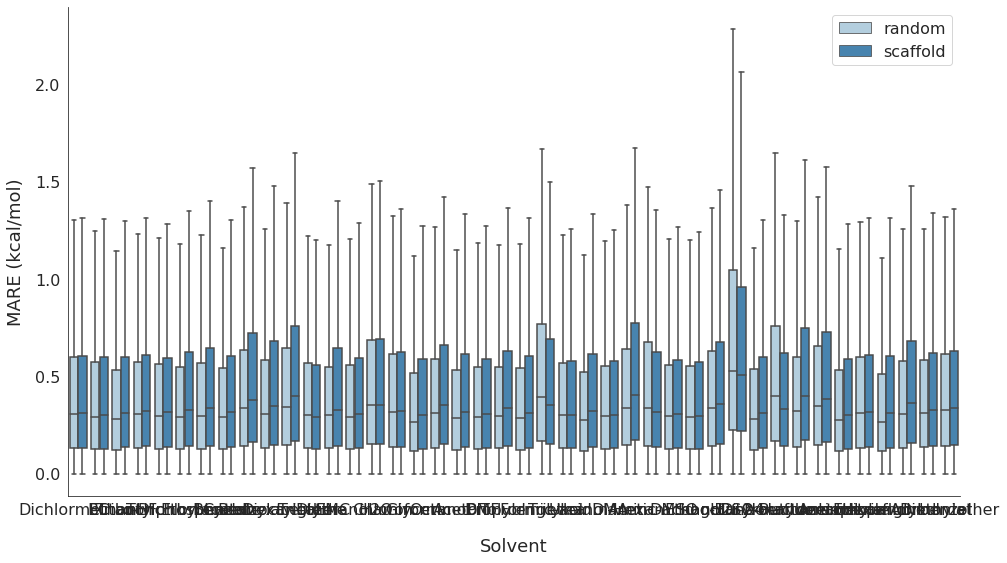

In [348]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=data_df,
    x="solvent",
    y="ARE (kcal/mol)",
    ax=ax1,
    palette="Blues",
    hue="split",
#     order=ordered_solvents,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("MARE (kcal/mol)", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [ ]:
# fig, ax1 = plt.subplots(figsize=(8, 9))
# sns.set_style("white")

# sns.boxplot(
#     data=data_df[data_df["ensemble"]==1],
#     x="solvent_class",
#     y="ARE (kcal/mol)",
#     ax=ax1,
#     palette="Blues",
#     order=solvent_class_order,
#     showfliers=False,
# )

# ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
# ax1.set_ylabel("MARE (kcal/mol)", fontsize=18, labelpad=10)
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_class_order, fontsize=16, rotation=60, rotation_mode="default", ha="right")
# ax1.tick_params(axis='x', labelsize=16)
# ax1.tick_params(axis='y', labelsize=16)

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=data_df,
    x="solvent",
    y="SRE (kcal/mol)",
    ax=ax1,
    palette="Blues",
#     order=solvent_order,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("MSRE (kcal/mol)", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

In [41]:
from scipy.spatial.distance import jaccard


def process_results(df):
    
    if len(df) < 3:
        return None
    
    mol_id = df.index[0][0]
    solvent = df.index[0][1]
    n_confs = len(df)
    pearsonr = df["dG_pred (kcal/mol)"].corr(df["dG_true (kcal/mol)"], method='pearson')
    spearmanr = df["dG_pred (kcal/mol)"].corr(df["dG_true (kcal/mol)"], method='spearman')
    
    df_relevant = df[df["dG_true (kcal/mol)"]<=1]
    pearsonr_relevant = df_relevant["dG_pred (kcal/mol)"].corr(df_relevant["dG_true (kcal/mol)"], method='pearson')
    spearmanr_relevant = df_relevant["dG_pred (kcal/mol)"].corr(df_relevant["dG_true (kcal/mol)"], method='spearman')

    # lowest energy conf identification
    true_lec_id = df[df["dG_true (kcal/mol)"]==0].index[0][-1]
    pred_lec_id = df[df["dG_pred (kcal/mol)"]==0].index[0][-1]
    pred_lec_idx = df["dG_pred (kcal/mol)"].argsort().loc[slice(None), slice(None), true_lec_id].values[0]

    # similarity between relevant confs predicted
    true_relevant_confs = (df["dG_true (kcal/mol)"]<=1).values
    pred_relevant_confs = (df["dG_pred (kcal/mol)"]<=1).values
    jaccard_sim = 1 - jaccard(true_relevant_confs, pred_relevant_confs)

    # G(solution) using the lowest predicted conformer
    true_lec_gsoln = df.loc[(slice(None), slice(None), true_lec_id)]["G(solution)"].values[0]
    conf_corr_true_gsoln = (R*T)*np.log(np.exp(-df["dG_true (kcal/mol)"]/(R*T)).sum())
    gsoln_true_all_confs = true_lec_gsoln - conf_corr_true_gsoln
    
    pred_lec_gsoln = df.loc[(slice(None), slice(None), pred_lec_id)]["G(solution)"].values[0]
    conf_corr_pred_gsoln = (R*T)*np.log(np.exp(-df["dG_pred (kcal/mol)"]/(R*T)).sum())
    gsoln_pred_all_confs = pred_lec_gsoln - conf_corr_pred_gsoln
    
    gsoln_error = gsoln_true_all_confs - gsoln_pred_all_confs
    pred_lec_gsoln_error = pred_lec_gsoln - true_lec_gsoln
    
    # partition functions
#     model_conf_factors = df["pred_conf_factor"].sort_values(ascending=False)
#     model_partition_function = model_conf_factors.sum()
#     model_partition_function_contributions = np.cumsum(model_conf_factors) / model_partition_function
#     predicted_idx = np.argmax(model_partition_function_contributions > delta)
#     percent_computation_saved = 100 - 100*((predicted_idx+1) / n_confs)  # idx is 0-indexed
    
    return {
        'mol_id': mol_id,
        'solvent': solvent,
        'n_confs': n_confs,
        'n_relevant_confs': len(df_relevant),
        'percent_relevant_confs': len(df_relevant) / len(df) * 100,
        'pearsonr': pearsonr,
        'pearsonr_relevant': pearsonr_relevant,
        'spearmanr': spearmanr,
        'spearmanr_relevant': spearmanr_relevant,
        'pred_lec_idx': pred_lec_idx,
        'pred_lec_gsoln_error': pred_lec_gsoln_error,
        'pred_lec_percent': pred_lec_idx/len(df) * 100,
        'jaccard_sim': jaccard_sim,
        "gsoln_error": gsoln_error,
        "true_gsoln": gsoln_true_all_confs,
        "pred_gsoln": gsoln_pred_all_confs,
    }

dict_list = Parallel(n_jobs=-1, backend="multiprocessing", verbose=5)(delayed(process_results)(df) \
                                        for _, df in data_df.groupby(["mol_id", "solvent"]))
per_mol_data_df = pd.DataFrame([x for x in dict_list if x])
per_mol_data_df = add_mol_properties(per_mol_data_df)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 16 concurrent workers.
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(

[Parallel(n_jobs=-1)]: Done 39392 tasks      | elapsed:   35.6s
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
[Parallel(n_jobs=-1)]: Done 46592 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 54368 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 62720 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 71648 tasks      | elapsed:  1.1min
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
[Parallel(n_jobs=-1)]: Done 81152 tasks      | elapsed:  1.2min
/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning:

### how well can the model identify the lowest energy conformer?

In [42]:
thresholds = np.array(np.arange(0, 10, 1).tolist() + np.arange(10, 210, 10).tolist())
lec_check = np.expand_dims(per_mol_data_df["pred_lec_idx"].values, -1) <= np.expand_dims(thresholds, 0)
lec_check_df = pd.DataFrame(lec_check)
lec_check_df.columns = thresholds
lec_check_df = pd.concat([per_mol_data_df, lec_check_df], axis=1)

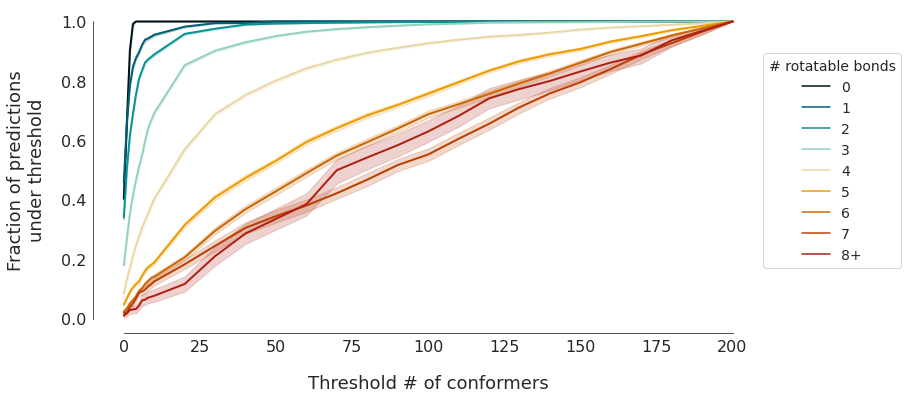

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("white")

palette = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]


lec_check_df_melt = lec_check_df.melt(
                        id_vars=["mol_id", "solvent", "n_rotatable_bonds_binned", "n_confs"], value_vars=thresholds,
                        var_name="threshold", value_name="check")
lec_check_df_melt["n_rotatable_bonds_binned"] = lec_check_df_melt["n_rotatable_bonds_binned"].astype("str")

sns.lineplot(
    data=lec_check_df_melt,
    x="threshold",
    y="check",
    hue="n_rotatable_bonds_binned",
    hue_order=['(-1, 0]', '(0, 1]', '(1, 2]', '(2, 3]', '(3, 4]', '(4, 5]',  '(5, 6]', '(6, 7]', '(7, 12]'],
    ax=ax1,
    linewidth=2,
    palette=palette[:-1],
)

sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

# ax1.set_xscale('log')
ax1.set_xlabel("Threshold # of conformers", fontsize=18, labelpad=20)
ax1.set_ylabel("Fraction of predictions\nunder threshold", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
handles = ax1.get_legend().legendHandles
ax1.legend(handles=handles, ncol=1, fontsize=14, title="# rotatable bonds",  title_fontsize=14, borderaxespad=2,
           labels=x_labels, loc=(1.0, 0.2),)

plt.savefig("../exps/plots/model_lec_identification.pdf", bbox_inches="tight")

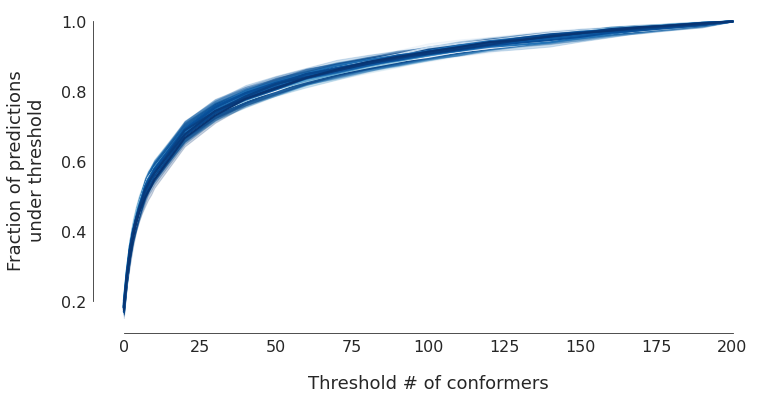

In [44]:
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.lineplot(
    data=lec_check_df_melt,
    x="threshold",
    y="check",
    hue="solvent",
    hue_order=ordered_solvents,
    ax=ax1,
    linewidth=2,
    palette="Blues",
)

sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

# ax1.set_xscale('log')
ax1.set_xlabel("Threshold # of conformers", fontsize=18, labelpad=20)
ax1.set_ylabel("Fraction of predictions\nunder threshold", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.get_legend().remove()
plt.savefig("../exps/plots/model_lec_identification_solvents.pdf", bbox_inches="tight")

### checking LEC of model doesn't account for conformers with near degenerate energies
### how does the model perform when considering these?

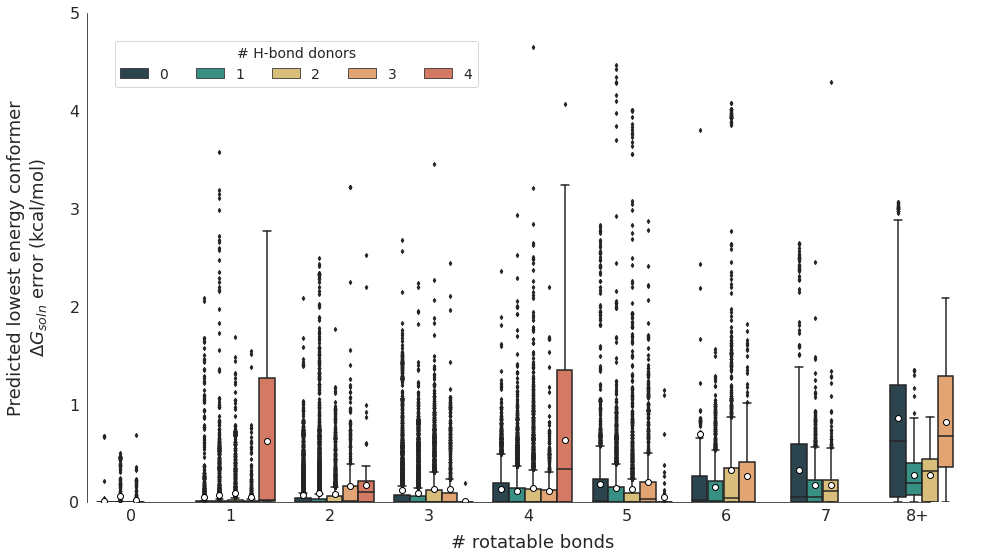

In [61]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df,
    x="n_rotatable_bonds_binned",
    y="pred_lec_gsoln_error",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
)

ax1.set_ylim(0, 5)
sns.despine(offset=0, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted lowest energy conformer\n$\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

plt.savefig("../exps/plots/model_lec_gsoln_error.pdf", bbox_inches="tight")

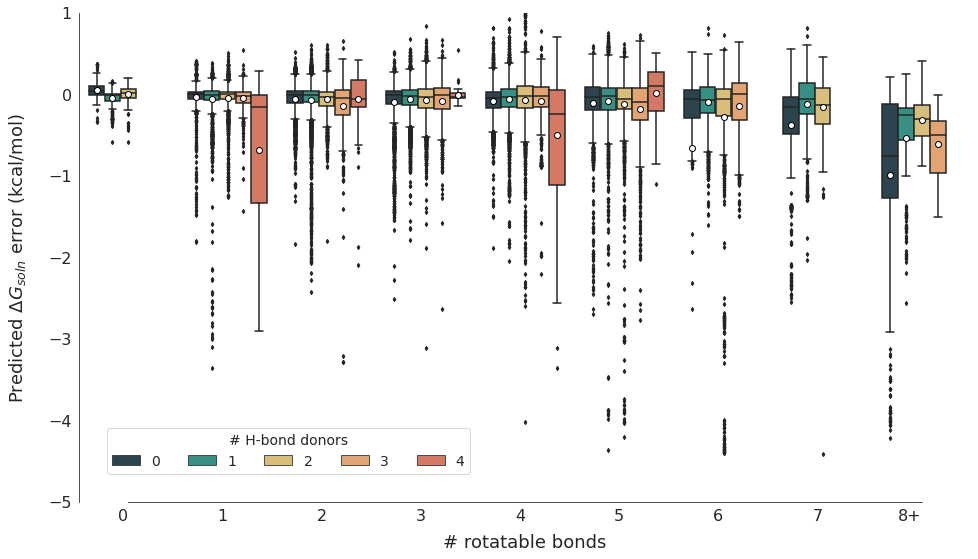

In [62]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df,
    x="n_rotatable_bonds_binned",
    y="gsoln_error",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
)

ax1.set_ylim(-5, 1)
sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted $\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='lower left', borderaxespad=2)

plt.savefig("../exps/plots/model_gsoln_error.pdf", bbox_inches="tight")

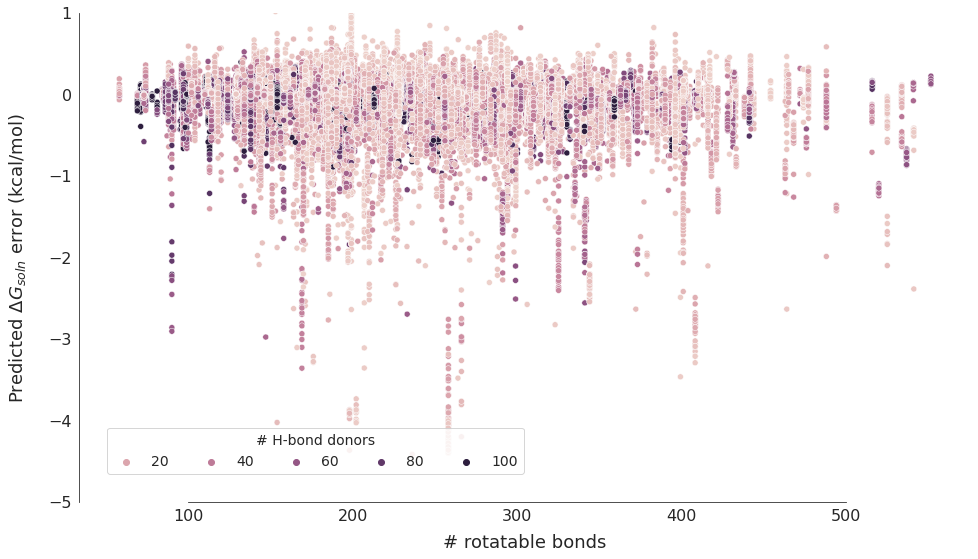

In [50]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.scatterplot(
    data=per_mol_data_df,
    x="mol_weight",
    y="gsoln_error",
    hue="percent_relevant_confs",
    ax=ax1,
#     palette=palette,
#     order=solvent_order,
#     showfliers=True,
)

ax1.set_ylim(-5, 1)
sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted $\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='lower left', borderaxespad=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


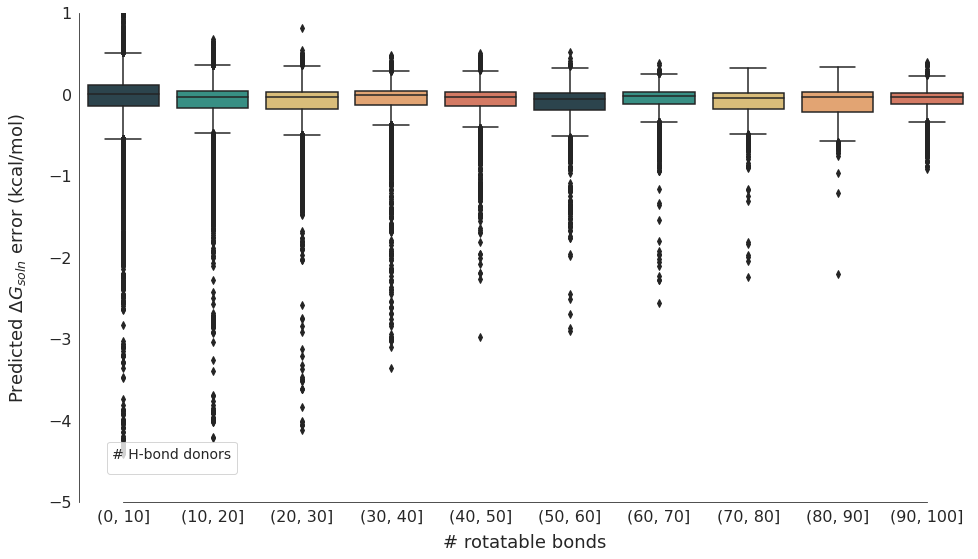

In [51]:
percent_relevant_confs_bins = np.arange(0, 101, 10).tolist()
per_mol_data_df["percent_relevant_confs_binned"] = pd.cut(per_mol_data_df["percent_relevant_confs"], percent_relevant_confs_bins)


fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=per_mol_data_df,
    x="percent_relevant_confs_binned",
    y="gsoln_error",
#     hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

ax1.set_ylim(-5, 1)
sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted $\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='lower left', borderaxespad=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


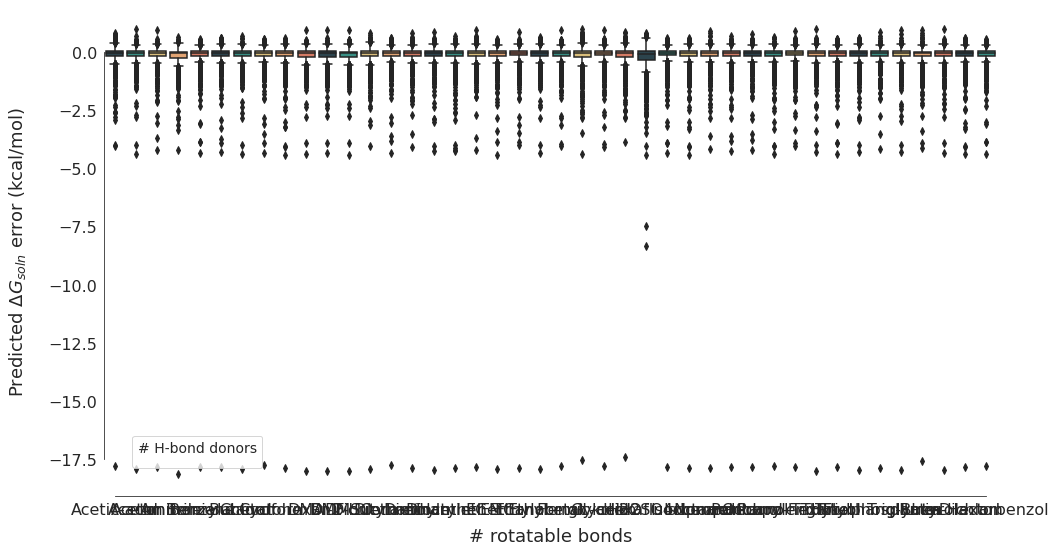

In [52]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df,
    x="solvent",
    y="gsoln_error",
#     hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

# ax1.set_ylim(-5, 1)
sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted $\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='lower left', borderaxespad=2)

# plt.savefig("../exps/plots/model_lec_gsoln_error.pdf", bbox_inches="tight")

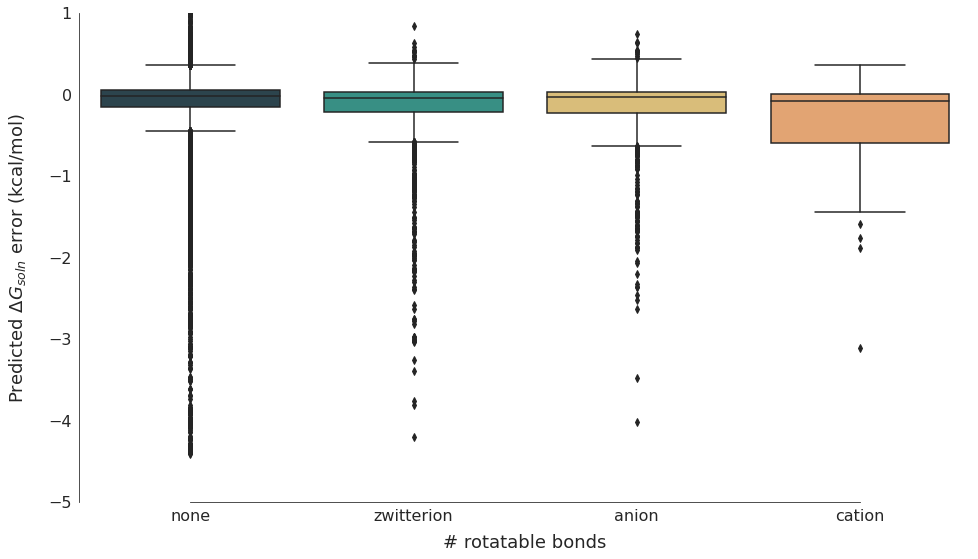

In [53]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df,
    x="ion",
    y="gsoln_error",
#     hue="ion",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

ax1.set_ylim(-5, 1)
sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted $\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
# ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", title_fontsize=14, loc='lower left', borderaxespad=2)

# plt.savefig("../exps/plots/model_gsoln_error.pdf", bbox_inches="tight")

(-5.0, 1.0)

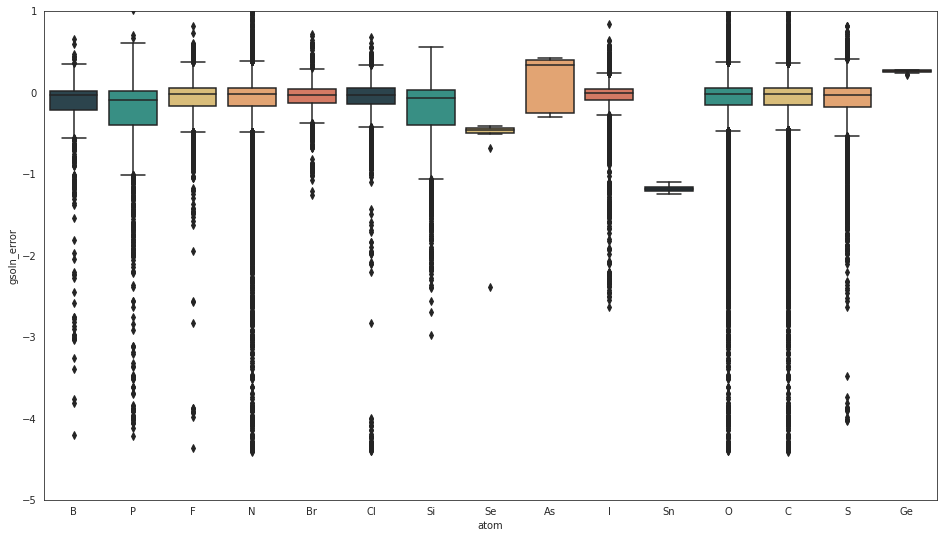

In [54]:
unique_atoms = list(set().union(*per_mol_data_df.atoms.values.tolist()))
atoms_df = per_mol_data_df.melt(id_vars=["mol_id", "solvent", "gsoln_error", "pred_lec_gsoln_error"], value_vars=unique_atoms,
                                var_name="atom", value_name="count")
atoms_df["exists"] = atoms_df["count"] > 0



fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=atoms_df[atoms_df["exists"]==True],
    x="atom",
    y="gsoln_error",
#     hue="ion",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

ax1.set_ylim(-5, 1)

In [298]:
atoms_df[atoms_df["gsoln_error"]<-17]

,mol_id,solvent,gsoln_error,atom,count,exists
9912,epa_DTXCID60362757,Acetic-acid,-17.604414,C,29,True
9913,epa_DTXCID60362757,Aceton,-17.719350,C,29,True
9914,epa_DTXCID60362757,Acetonitrile,-17.623150,C,29,True
9915,epa_DTXCID60362757,Ammonia,-17.717410,C,29,True
9916,epa_DTXCID60362757,Benzene,-17.609214,C,29,True
...,...,...,...,...,...,...
1035421,epa_DTXCID60362757,Triglyme,-17.673426,P,1,True
1035422,epa_DTXCID60362757,Urea,-17.323142,P,1,True
1035423,epa_DTXCID60362757,g-Butyrolacton,-17.692724,P,1,True
1035424,epa_DTXCID60362757,n-Hexan,-17.625777,P,1,True


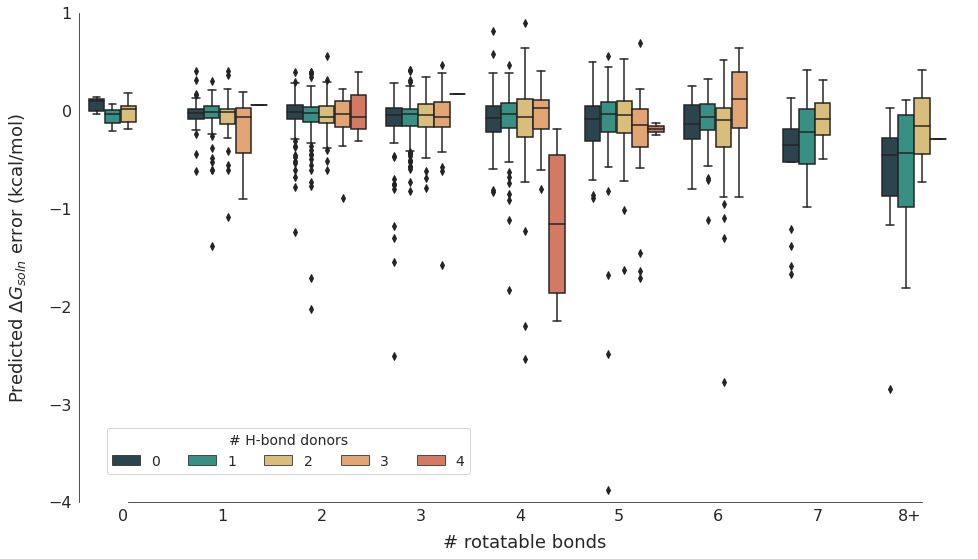

In [55]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["solvent"]=="H2O"],
    x="n_rotatable_bonds_binned",
    y="gsoln_error",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

ax1.set_ylim(-4, 1)
sns.despine(offset=0, trim=True)
x_labels = [str(i) for i in range(8)] + ["8+"]

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted $\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='lower left', borderaxespad=2)

# plt.savefig("../exps/plots/model_lec_gsoln_error.pdf", bbox_inches="tight")

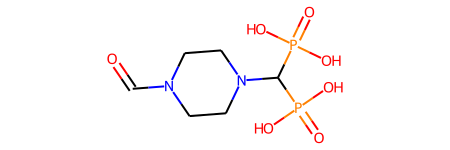

7.000000000000001


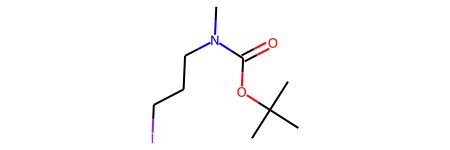

59.09090909090909


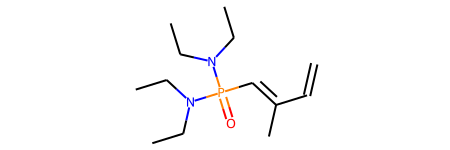

24.5


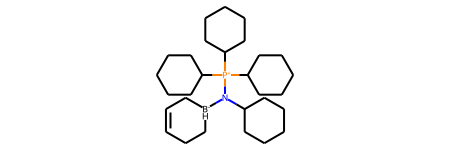

2.0202020202020203


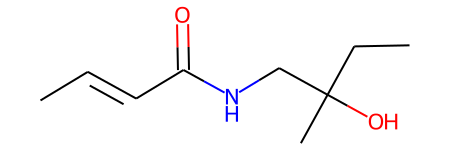

8.0


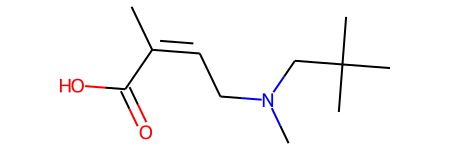

2.380952380952381


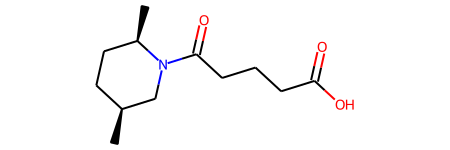

1.342281879194631


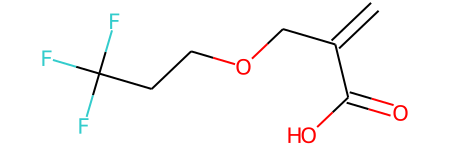

15.107913669064748


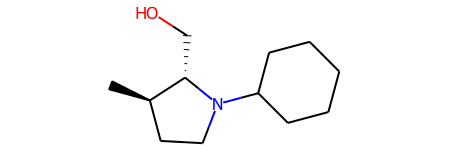

4.0


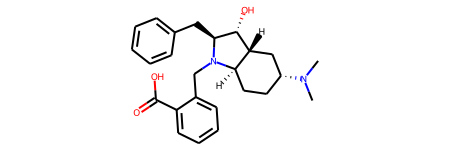

16.0


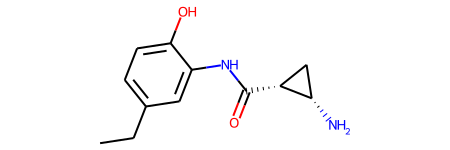

2.941176470588235


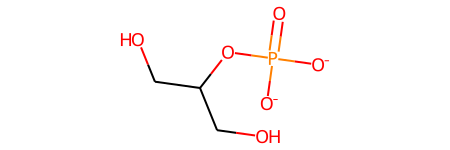

0.7518796992481203


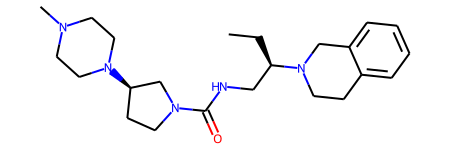

3.5000000000000004


In [336]:
for _, df in per_mol_data_df[(per_mol_data_df["solvent"]=="H2O") & (per_mol_data_df["gsoln_error"]<-2)].iterrows():
    smi = df["solute_smi"]
    mol = Chem.MolFromSmiles(smi)
    display(mol)
    print(df["percent_relevant_confs"])

In [328]:
df

(2502,
 mol_id                                                      epa_DTXCID1046974
 solvent                                                                   H2O
 n_confs                                                                   200
 n_relevant_confs                                                           14
 pearsonr                                                             0.832674
 pearsonr_relevant                                                   -0.610638
 pred_lec_idx                                                               80
 pred_lec_gsoln_error                                                 1.760518
 pred_lec_percent                                                         40.0
 jaccard_sim                                                          0.058824
 gsoln_error                                                         -2.158398
 true_gsoln                                                     -976728.365645
 pred_gsoln                                  

In [317]:
# which one went wrong???

error_smiles = per_mol_data_df[per_mol_data_df["gsoln_error"]<-17]["solute_smi"].values[0]
per_mol_data_df[per_mol_data_df["solute_smi"]==error_smiles]

,mol_id,solvent,n_confs,n_relevant_confs,pearsonr,pearsonr_relevant,pred_lec_idx,pred_lec_gsoln_error,pred_lec_percent,jaccard_sim,...,O,Se,Sn,As,N,Ge,P,n_hetero_atoms,percent_hetero_atoms,ion
9912,epa_DTXCID60362757,Acetic-acid,99,2,0.319692,1.0,41,17.704847,41.414141,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9913,epa_DTXCID60362757,Aceton,99,2,0.309320,1.0,55,17.803318,55.555556,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9914,epa_DTXCID60362757,Acetonitrile,99,2,0.315962,1.0,41,17.707955,41.414141,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9915,epa_DTXCID60362757,Ammonia,99,2,0.277393,1.0,55,17.870957,55.555556,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9916,epa_DTXCID60362757,Benzene,99,2,0.306216,1.0,51,17.696721,51.515152,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9917,epa_DTXCID60362757,Benzylacetat,99,2,0.304712,1.0,51,17.706042,51.515152,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9918,epa_DTXCID60362757,Butanon,99,2,0.308222,1.0,55,17.790412,55.555556,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9919,epa_DTXCID60362757,Chloroform,99,2,0.292598,1.0,55,17.579847,55.555556,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9920,epa_DTXCID60362757,Cyclohexan,99,2,0.302067,1.0,51,17.712018,51.515152,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion
9921,epa_DTXCID60362757,DMA,99,2,0.309507,1.0,41,17.820765,41.414141,0.0,...,0,0,0,0,1,0,1,3,0.09375,zwitterion


In [227]:
per_mol_data_df["ion"] = "none"
per_mol_data_df.loc[per_mol_data_df["fc"]>0, "ion"] = "cation"
per_mol_data_df.loc[per_mol_data_df["fc"]<0, "ion"] = "anion"
per_mol_data_df.loc[(per_mol_data_df["fc"]==0) & ((per_mol_data_df["max_fc"]!=0) | (per_mol_data_df["min_fc"]!=0)), "ion"] = "zwitterion"

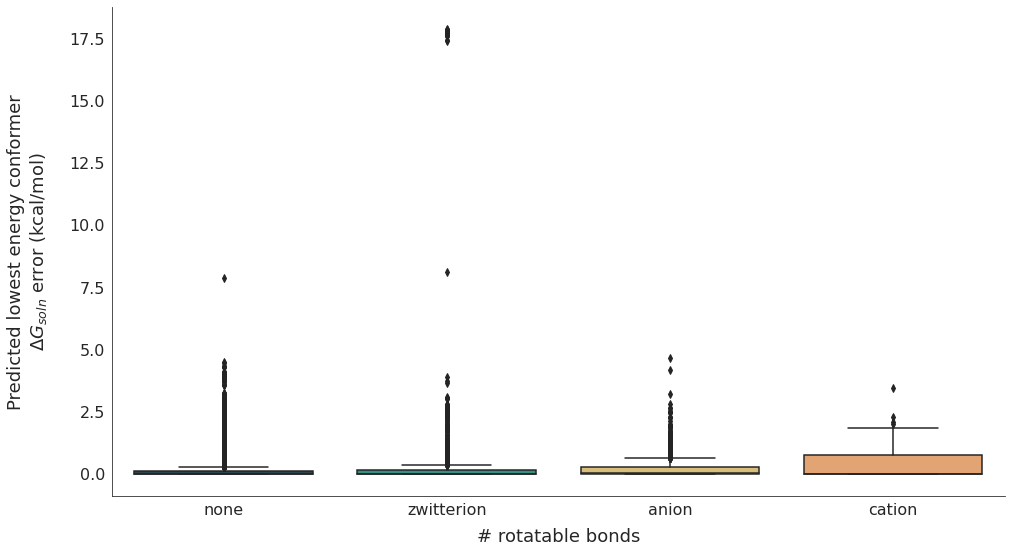

In [231]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df,
    x="ion",
    y="pred_lec_gsoln_error",
#     hue="ion",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=10)
ax1.set_ylabel("Predicted lowest energy conformer\n$\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
x_labels = [str(i) for i in range(8)] + ["8+"]
# ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

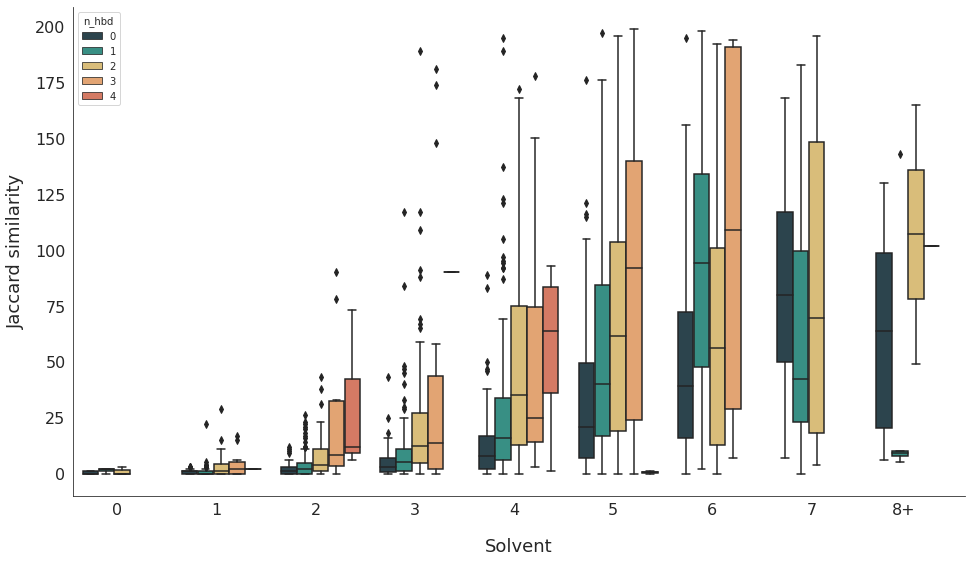

In [58]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=per_mol_data_df[(per_mol_data_df["solvent"]=="H2O")],
    x="n_rotatable_bonds_binned",
    y="pred_lec_idx",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Jaccard similarity", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

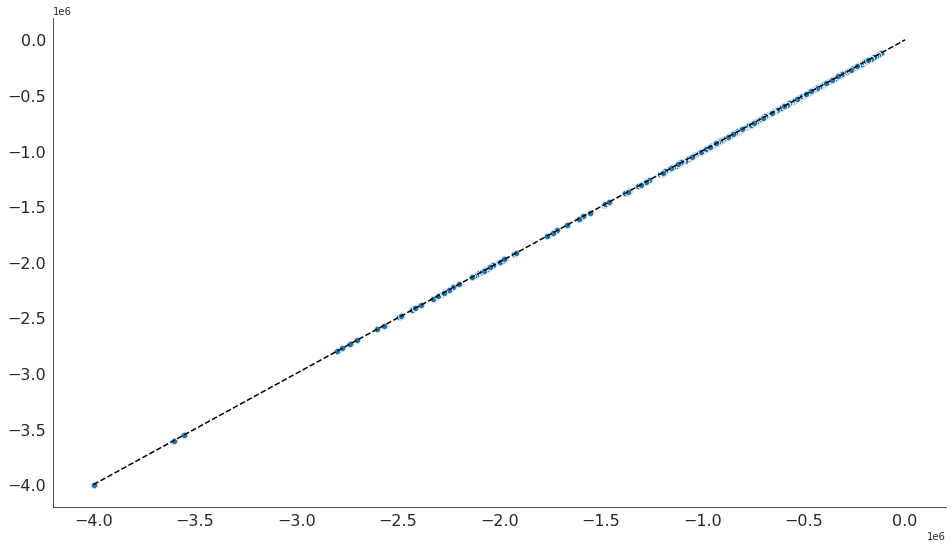

In [56]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.scatterplot(
    data=per_mol_data_df[(per_mol_data_df["true_gsoln"]>-4e6)],
    x="true_gsoln",
    y="pred_gsoln",
#     hue="n_hbd",
    ax=ax1,
#     palette=palette,
#     order=solvent_order,
)

sns.lineplot(x=np.arange(-4e6, 1e6, 1e6), y=np.arange(-4e6, 1e6, 1e6), color="black", linestyle='--')

ax1.set_xlabel("", fontsize=18, labelpad=20)
ax1.set_ylabel("", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

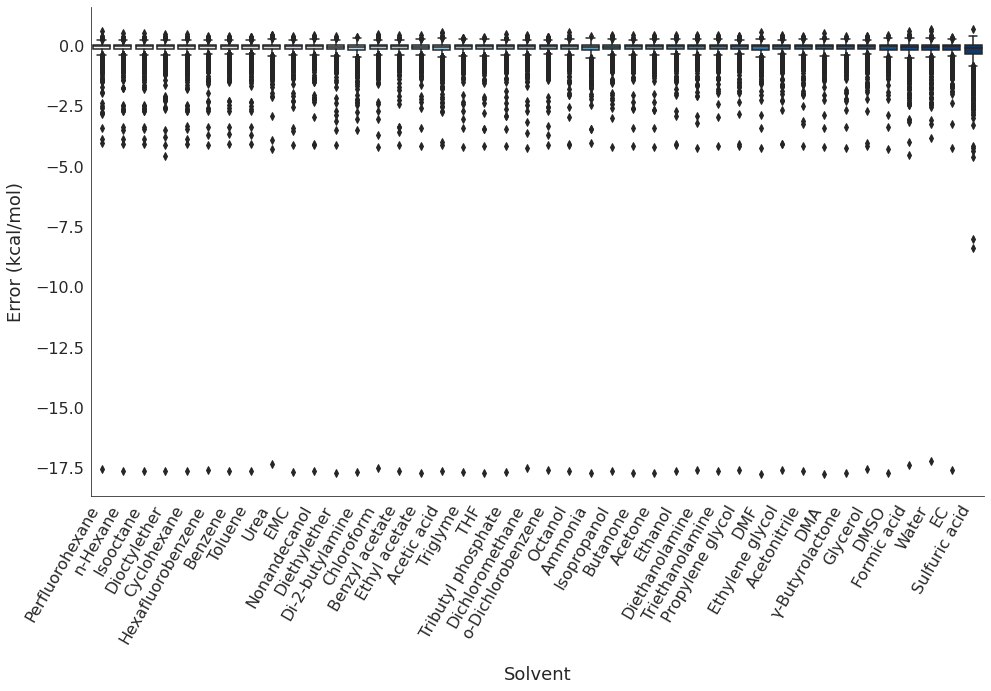

In [57]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="solvent",
    y="gsoln_error",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Error (kcal/mol)", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

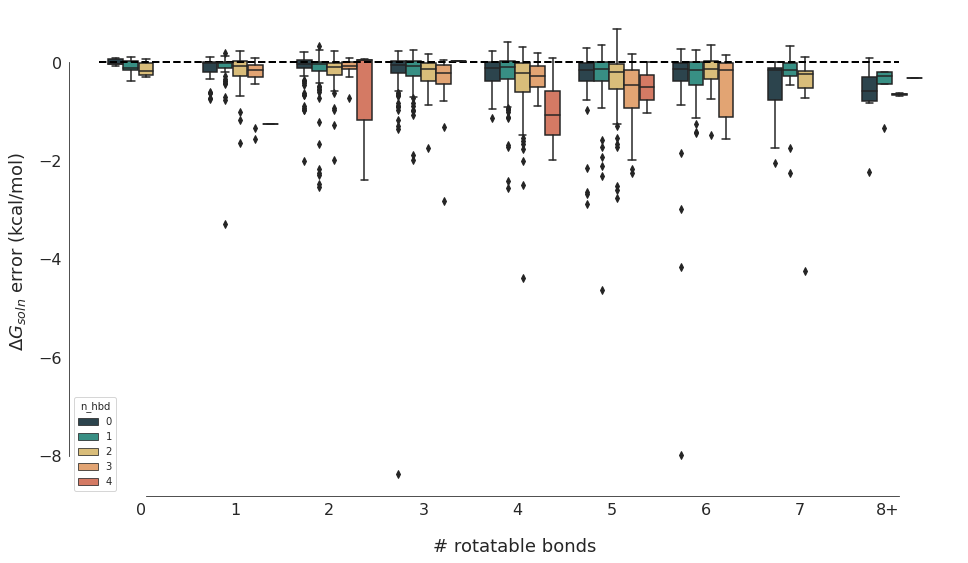

In [81]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df[(per_mol_data_df["n_confs"]>2) & (per_mol_data_df["solvent"]=="H2SO4")],
    x="n_rotatable_bonds_binned",
    y="gsoln_error",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

sns.despine(offset=0, trim=True)
ax1.hlines(0, -0.5, 8, linewidth=2, linestyle="--", color='black')

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("$\Delta G_{soln}$ error (kcal/mol)", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

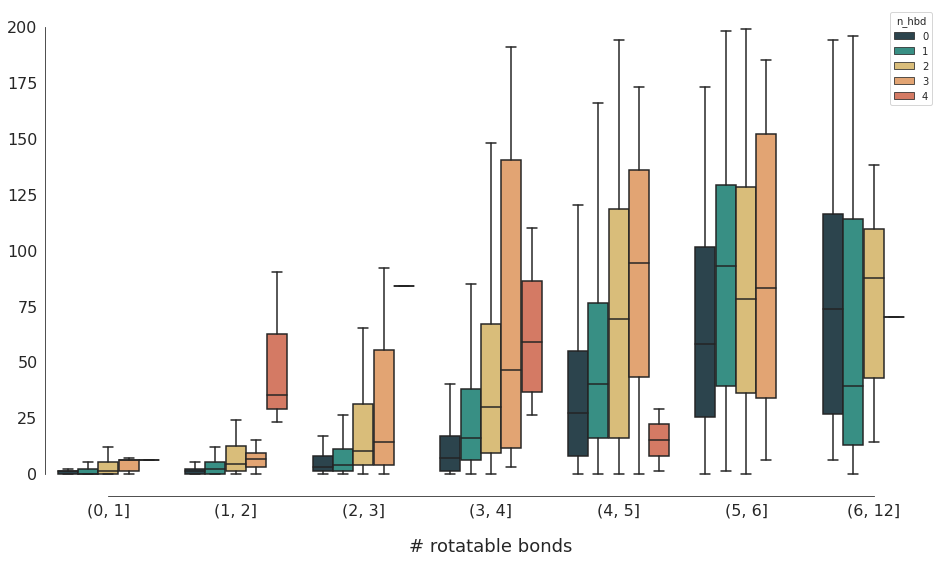

In [25]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df[(per_mol_data_df["n_confs"]>2) & (per_mol_data_df["solvent"]=="Acetic-acid")],
    x="n_rotatable_bonds_binned",
    y="pred_lec_idx",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=False,
)

sns.despine(offset=0, trim=True)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

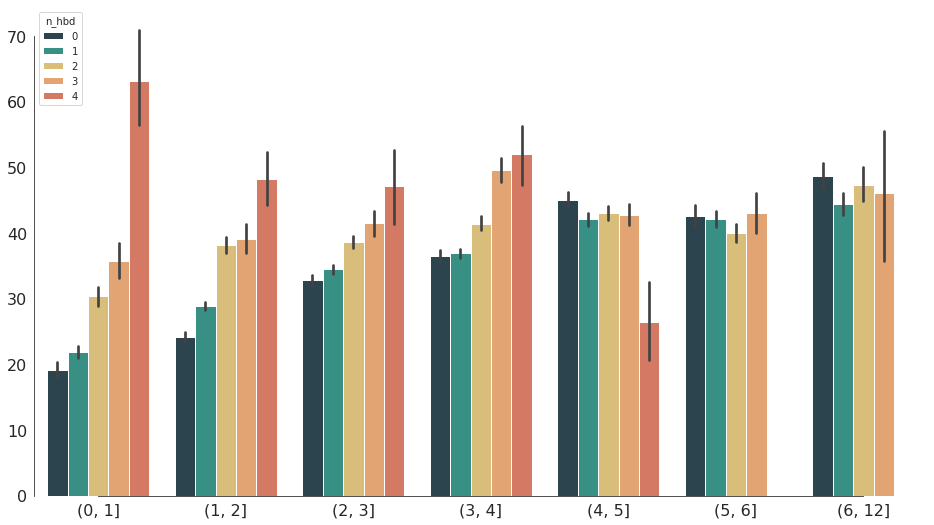

In [26]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.barplot(
    data=per_mol_data_df[(per_mol_data_df["n_confs"]>2)],
    x="n_rotatable_bonds_binned",
    y="pred_lec_percent",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
)

sns.despine(offset=0, trim=True)

ax1.set_xlabel("", fontsize=18, labelpad=20)
ax1.set_ylabel("", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

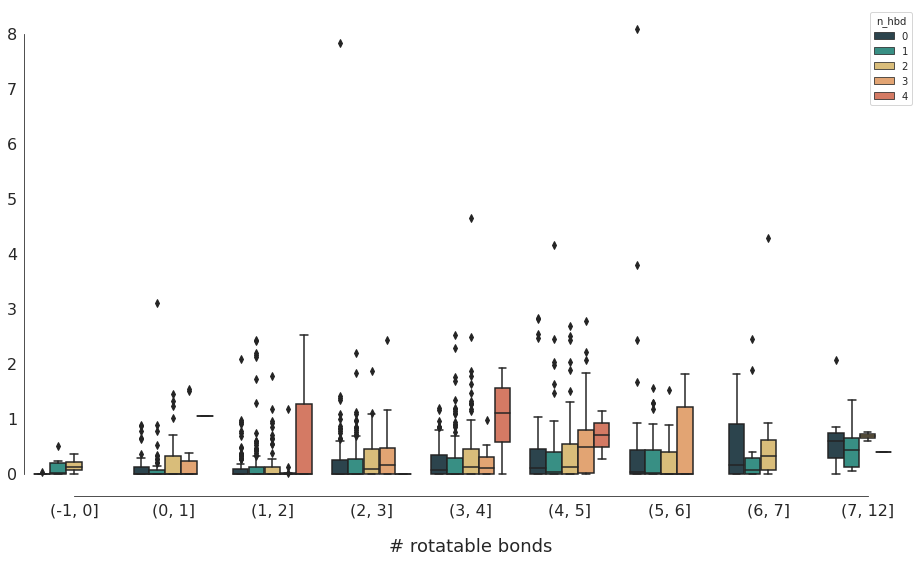

In [83]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=per_mol_data_df[(per_mol_data_df["n_confs"]>2) & (per_mol_data_df["solvent"]=="H2SO4")],
    x="n_rotatable_bonds_binned",
    y="pred_lec_gsoln_error",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=True,
)

sns.despine(offset=0, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

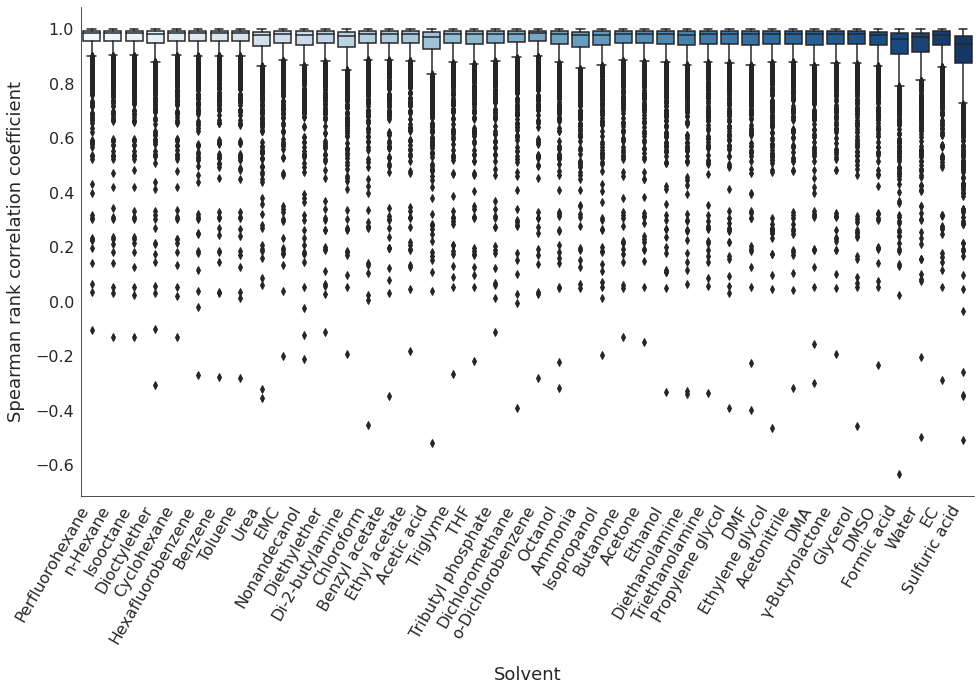

In [374]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>10],
    x="solvent",
    y="pearsonr",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Spearman rank correlation coefficient", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/model_spearman_solvent.pdf", bbox_inches="tight")

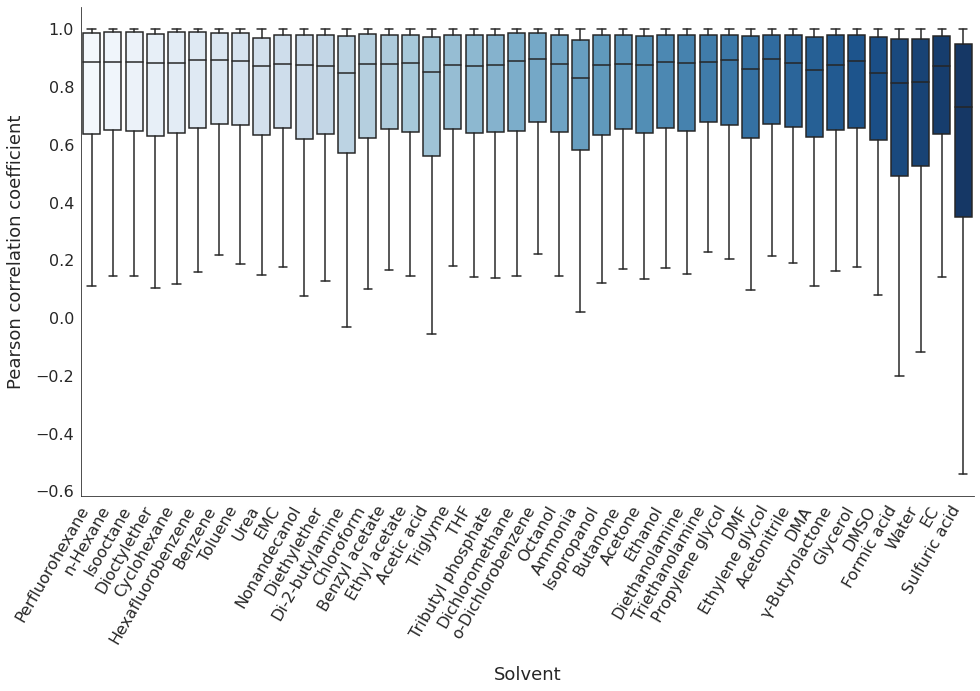

In [29]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="solvent",
    y="pearsonr_relevant",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Pearson correlation coefficient", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

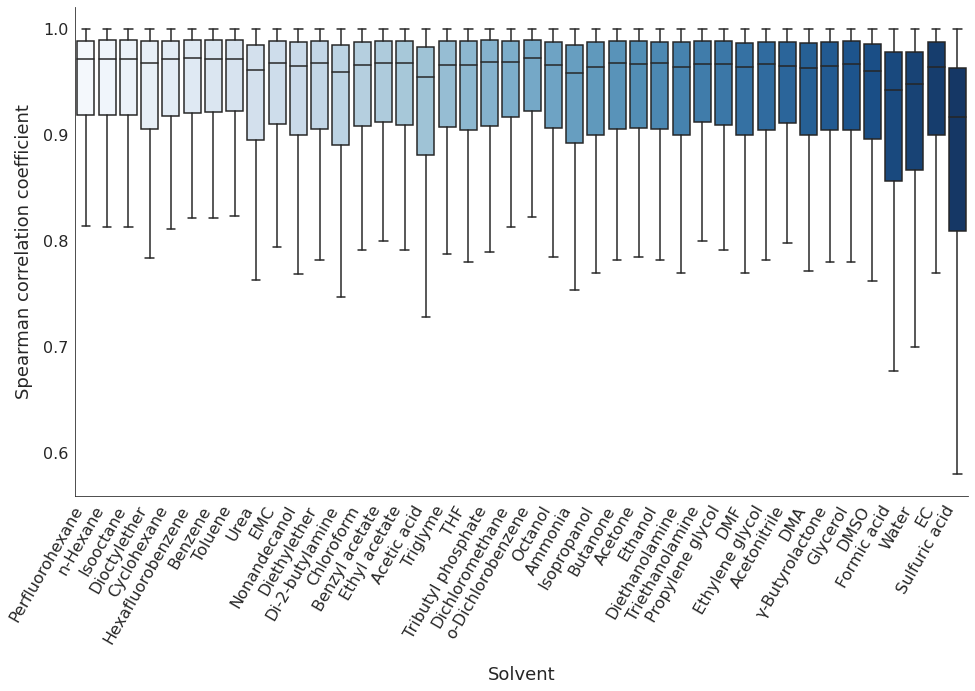

In [369]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="solvent",
    y="spearmanr",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Spearman correlation coefficient", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

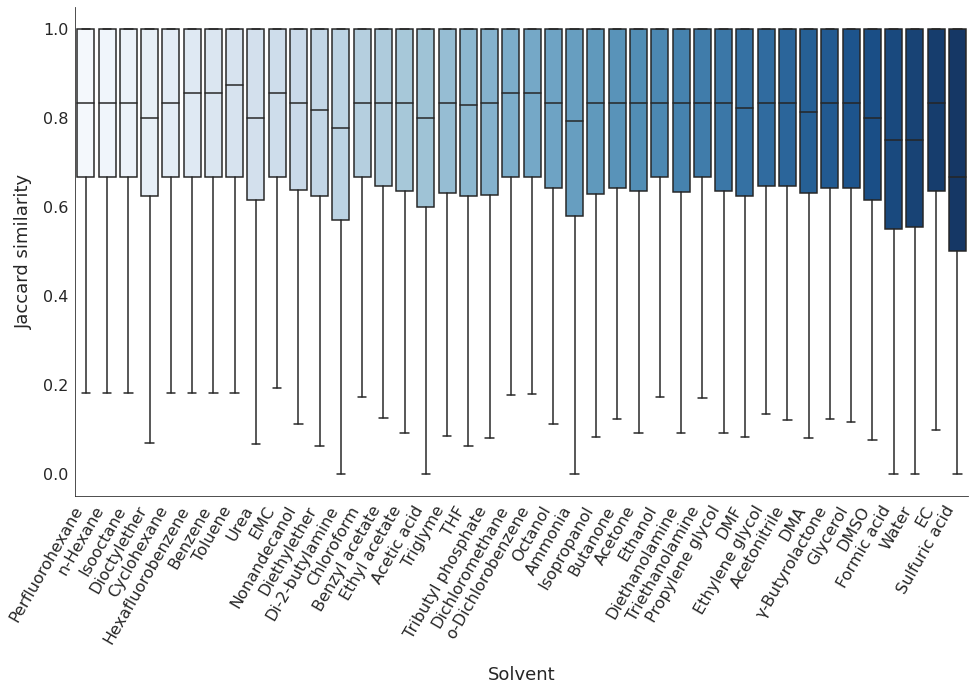

In [30]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="solvent",
    y="jaccard_sim",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Jaccard similarity", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

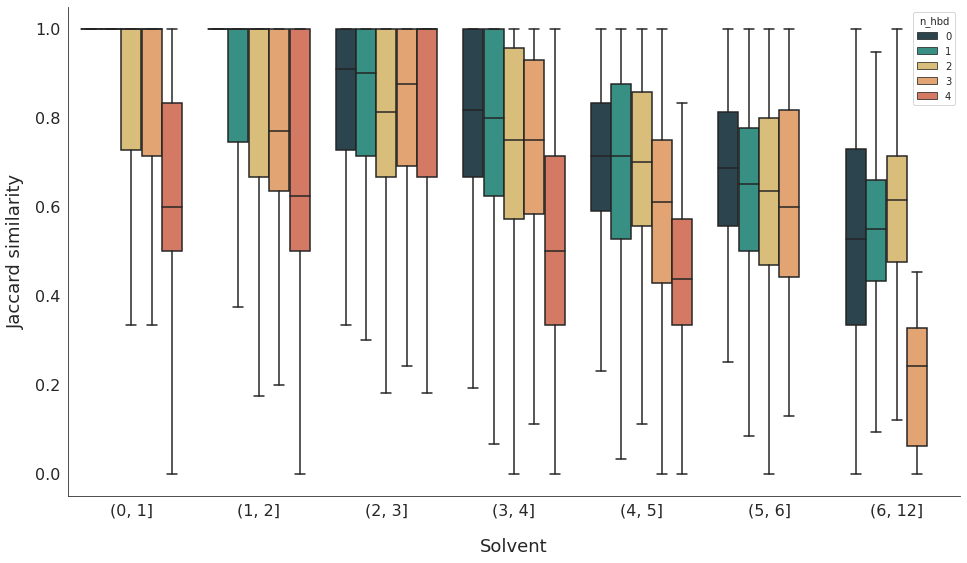

In [31]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="n_rotatable_bonds_binned",
    y="jaccard_sim",
    hue="n_hbd",
    ax=ax1,
    palette=palette,
#     order=solvent_order,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Jaccard similarity", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

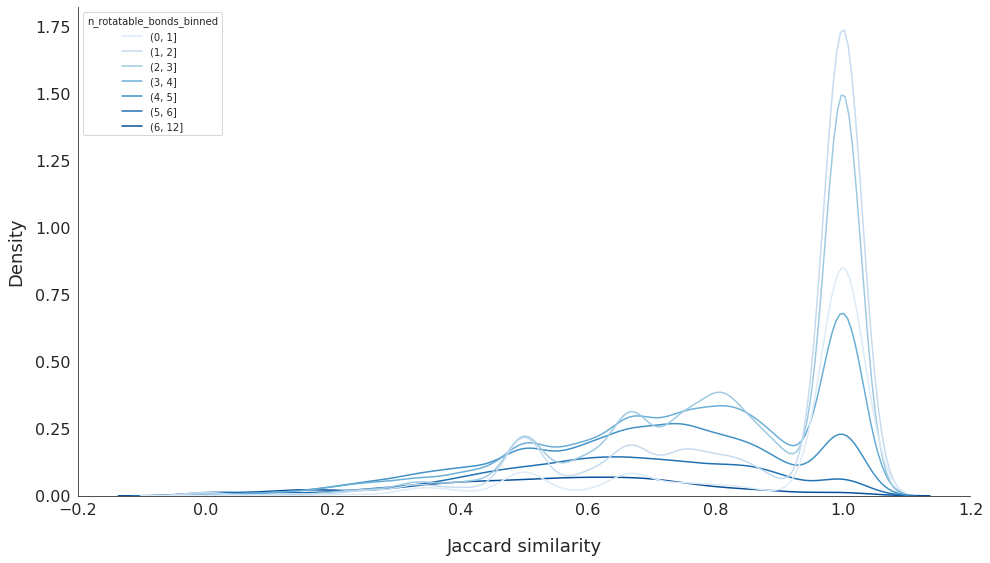

In [32]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.kdeplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="jaccard_sim",
    hue="n_rotatable_bonds_binned",
    ax=ax1,
    palette="Blues",
#     order=solvent_order,
)

ax1.set_xlabel("Jaccard similarity", fontsize=18, labelpad=20)
ax1.set_ylabel("Density", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=solvent_labels, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=per_mol_data_df[per_mol_data_df["n_confs"]>2],
    x="solvent",
    y="pred_lec_percent",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=False,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("Jaccard similarity", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)